# Set-Up

In [1]:
import deepxde as dde
import numpy as np

import tensorflow.compat.v1 as tf
import matplotlib.pyplot as plt

import pandas as pd

Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.



Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import os;os.environ["TF_USE_LEGACY_KERAS"]="1"

In [3]:
dde.config.set_random_seed(1234)
dde.config.set_default_float("float64")

Set the default float type to float64


# PDE

In [4]:
#computational domain
geom = dde.geometry.Rectangle([0, 0], [1, 1])

In [5]:
#pde
def pde(x, u):
    u_xx = dde.grad.hessian(u, x, i=0, j=0)
    u_yy = dde.grad.hessian(u, x, i=1, j=1)
    return u_xx + u_yy

# Soft Constraints

In [6]:
#bcs problem 1
bc_top_1 = dde.icbc.DirichletBC(geom, 
                              lambda x: np.sin(np.pi * x[:, 0:1]), 
                              lambda x, on_boundary: on_boundary and dde.utils.isclose(x[1], 1.0),)

bc_bottom_1 = dde.icbc.DirichletBC(geom,
                                 lambda x: 0, 
                                 lambda x, on_boundary: on_boundary and dde.utils.isclose(x[1], 0.0),)

bc_left_1 = dde.icbc.DirichletBC(geom,
                               lambda x: 0, 
                               lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 0.0),)

bc_right_1 = dde.icbc.DirichletBC(geom,
                                lambda x: 0, 
                                lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 1.0),)

In [7]:
#bcs problem 2
bc_top_2 = dde.icbc.DirichletBC(geom, 
                              lambda x: -x[:, 0:1]**2 + x[:, 0:1], 
                              lambda x, on_boundary: on_boundary and dde.utils.isclose(x[1], 1.0),)

bc_bottom_2 = dde.icbc.DirichletBC(geom,
                                 lambda x: -x[:, 0:1]**2 + x[:, 0:1], 
                                 lambda x, on_boundary: on_boundary and dde.utils.isclose(x[1], 0.0),)

bc_left_2 = dde.icbc.DirichletBC(geom,
                               lambda x: -x[:, 1:2]**2 + x[:, 1:2], 
                               lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 0.0),)

bc_right_2 = dde.icbc.DirichletBC(geom,
                                lambda x: -x[:, 1:2]**2 + x[:, 1:2], 
                                lambda x, on_boundary: on_boundary and dde.utils.isclose(x[0], 1.0),)

In [8]:
#combine geometry, pde and bcs 
data_1_s = dde.data.PDE(
    geom,
    pde,
    [
        bc_top_1,
        bc_bottom_1,
        bc_left_1,
        bc_right_1
    ],
    num_domain=500,
    num_boundary=100,
    train_distribution='Sobol'
    )

data_2_s = dde.data.PDE(
    geom,
    pde,
    [
        bc_top_2,
        bc_bottom_2,
        bc_left_2,
        bc_right_2
    ],
    num_domain=500,
    num_boundary=100,
    train_distribution='Sobol'
    )

C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+501=501. 
  warnings.warn(
C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+103=103. 
  warnings.warn(
C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+501=501. 
  warnings.warn(
C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+103=103. 
  warnings.warn(


In [9]:
initializer = tf.keras.initializers.GlorotUniform(1234)

In [10]:
net_square_1_s = dde.nn.FNN([2] + [20] * 20 + [1], "tanh", initializer)
net_long_1_s = dde.nn.FNN([2] + [20] * 5 + [1], "tanh", initializer)
net_oblong_1_s = dde.nn.FNN([2] + [5] * 20 + [1], "tanh", initializer)

net_square_2_s = dde.nn.FNN([2] + [20] * 20 + [1], "tanh", initializer)
net_long_2_s = dde.nn.FNN([2] + [20] * 5 + [1], "tanh", initializer)
net_oblong_2_s = dde.nn.FNN([2] + [5] * 20 + [1], "tanh", initializer)

In [11]:
model_square_1_s = dde.Model(data_1_s, net_square_1_s)
model_long_1_s = dde.Model(data_1_s, net_long_1_s)
model_oblong_1_s = dde.Model(data_1_s, net_oblong_1_s)

model_square_2_s = dde.Model(data_2_s, net_square_2_s)
model_long_2_s = dde.Model(data_2_s, net_long_2_s)
model_oblong_2_s = dde.Model(data_2_s, net_oblong_2_s)

### Soft Constraints - Square

In [12]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_square_1_s.compile("adam", lr=0.001)
model_square_1_s.train(iterations=10000, display_every=1000)
model_square_1_s.compile("L-BFGS-B")
loss_history_square_1_s, train_state_square_1_s = model_square_1_s.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...




C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 4.351571 s


'compile' took 6.494388 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.79e-02, 4.15e-01, 4.74e-05, 3.32e-03, 1.83e-03]    [1.79e-02, 4.15e-01, 4.74e-05, 3.32e-03, 1.83e-03]    []  
1000      [3.04e-02, 3.56e-03, 2.25e-03, 3.73e-04, 2.06e-03]    [3.04e-02, 3.56e-03, 2.25e-03, 3.73e-04, 2.06e-03]    []  
2000      [3.03e-03, 2.46e-03, 4.44e-04, 5.81e-04, 1.44e-03]    [3.03e-03, 2.46e-03, 4.44e-04, 5.81e-04, 1.44e-03]    []  
3000      [6.23e-03, 6.06e-04, 3.39e-04, 2.33e-04, 5.73e-04]    [6.23e-03, 6.06e-04, 3.39e-04, 2.33e-04, 5.73e-04]    []  
4000      [9.64e-03, 2.08e-03, 6.48e-04, 3.22e-05, 2.10e-04]    [9.64e-03, 2.08e-03, 6.48e-04, 3.22e-05, 2.10e-04]    []  
5000      [4.54e-03, 1.67e-04, 1.59e-04, 4.07e-04, 4.30e-04]    [4.54e-03, 1.67e-04, 1.59e-04, 4.07e-04, 4.30e-04]    []  
6000      [8.72e-04, 6.83e-05, 1.53e-04, 1.97e-04, 3.62e-04]

In [13]:
dde.utils.external.save_loss_history(loss_history_square_1_s, 'laplace1_soft_square_loss')

Saving loss history to laplace1_soft_square_loss ...


In [14]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_square_2_s.compile("adam", lr=0.001)
model_square_2_s.train(iterations=10000, display_every=1000)
model_square_2_s.compile("L-BFGS-B")
loss_history_square_2_s, train_state_square_2_s = model_square_2_s.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.334802 s

'compile' took 2.462593 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.79e-02, 1.47e-02, 3.63e-02, 1.86e-02, 2.24e-02]    [1.79e-02, 1.47e-02, 3.63e-02, 1.86e-02, 2.24e-02]    []  
1000      [6.15e-06, 5.49e-03, 4.54e-03, 4.48e-03, 5.49e-03]    [6.15e-06, 5.49e-03, 4.54e-03, 4.48e-03, 5.49e-03]    []  
2000      [5.95e-05, 5.33e-03, 4.47e-03, 4.43e-03, 5.32e-03]    [5.95e-05, 5.33e-03, 4.47e-03, 4.43e-03, 5.32e-03]    []  
3000      [3.19e-05, 5.32e-03, 4.48e-03, 4.46e-03, 5.39e-03]    [3.19e-05, 5.32e-03, 4.48e-03, 4.46e-03, 5.39e-03]    []  
4000      [6.73e-05, 5.31e-03, 4.47e-03, 4.44e-03, 5.32e-03]    [6.73e-05, 5.31e-03, 4.47e-03, 4.44e-03, 5.32e-03]    []  
5000      [8.82e-05, 5.28e-03, 4.52e-03, 4.44e-03, 5.25e-03]    [8.82e-05, 5.28e-03, 4.52e-03, 4.44e-03, 5.25e-03]    []  
60

In [15]:
dde.utils.external.save_loss_history(loss_history_square_2_s, 'laplace2_soft_square_loss')

Saving loss history to laplace2_soft_square_loss ...


### Soft Constraints - Long

In [23]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_long_1_s.compile("adam", lr=0.001)
model_long_1_s.train(iterations=10000, display_every=1000)
model_long_1_s.compile("L-BFGS-B")
loss_history_long_1_s, train_state_long_1_s = model_long_1_s.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.445195 s

'compile' took 2.949138 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.85e-02, 8.79e-01, 4.04e-02, 5.94e-03, 1.13e-01]    [6.85e-02, 8.79e-01, 4.04e-02, 5.94e-03, 1.13e-01]    []  
1000      [1.56e-02, 3.91e-02, 3.59e-03, 1.29e-02, 1.17e-02]    [1.56e-02, 3.91e-02, 3.59e-03, 1.29e-02, 1.17e-02]    []  
2000      [5.44e-03, 2.65e-02, 1.39e-03, 5.86e-03, 1.48e-02]    [5.44e-03, 2.65e-02, 1.39e-03, 5.86e-03, 1.48e-02]    []  
3000      [4.04e-03, 1.57e-02, 1.31e-03, 2.60e-03, 9.20e-03]    [4.04e-03, 1.57e-02, 1.31e-03, 2.60e-03, 9.20e-03]    []  
4000      [3.76e-03, 1.15e-02, 8.87e-04, 2.18e-03, 6.48e-03]    [3.76e-03, 1.15e-02, 8.87e-04, 2.18e-03, 6.48e-03]    []  
5000      [2.59e-03, 8.29e-03, 7.48e-04, 1.94e-03, 4.55e-03]    [2.59e-03, 8.29e-03, 7.48e-04, 1.94e-03, 4.55e-03]    []  
60

In [24]:
dde.utils.external.save_loss_history(loss_history_long_1_s, 'laplace1_soft_long_loss')

Saving loss history to laplace1_soft_long_loss ...


In [25]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_long_2_s.compile("adam", lr=0.001)
model_long_2_s.train(iterations=10000, display_every=1000)
model_long_2_s.compile("L-BFGS-B")
loss_history_long_2_s, train_state_long_2_s = model_long_2_s.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.165448 s

'compile' took 1.638849 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [6.85e-02, 1.80e-01, 1.36e-01, 6.48e-02, 2.59e-01]    [6.85e-02, 1.80e-01, 1.36e-01, 6.48e-02, 2.59e-01]    []  
1000      [4.60e-05, 5.41e-03, 4.47e-03, 4.43e-03, 5.27e-03]    [4.60e-05, 5.41e-03, 4.47e-03, 4.43e-03, 5.27e-03]    []  
2000      [7.23e-05, 5.35e-03, 4.39e-03, 4.26e-03, 5.16e-03]    [7.23e-05, 5.35e-03, 4.39e-03, 4.26e-03, 5.16e-03]    []  
3000      [7.71e-04, 5.30e-03, 3.46e-03, 3.26e-03, 4.94e-03]    [7.71e-04, 5.30e-03, 3.46e-03, 3.26e-03, 4.94e-03]    []  
4000      [1.35e-03, 4.79e-03, 1.33e-03, 1.31e-03, 4.54e-03]    [1.35e-03, 4.79e-03, 1.33e-03, 1.31e-03, 4.54e-03]    []  
5000      [7.72e-03, 7.21e-03, 1.27e-03, 1.64e-03, 6.07e-03]    [7.72e-03, 7.21e-03, 1.27e-03, 1.64e-03, 6.07e-03]    []  
60

In [26]:
dde.utils.external.save_loss_history(loss_history_long_2_s, 'laplace2_soft_long_loss')

Saving loss history to laplace2_soft_long_loss ...


### Soft Constraints - Oblong

In [27]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_oblong_1_s.compile("adam", lr=0.001)
model_oblong_1_s.train(iterations=10000, display_every=1000)
model_oblong_1_s.compile("L-BFGS-B")
loss_history_oblong_1_s, train_state_oblong_1_s = model_oblong_1_s.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.302347 s

'compile' took 3.106424 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.80e-03, 4.65e-01, 4.34e-04, 1.23e-04, 1.05e-03]    [1.80e-03, 4.65e-01, 4.34e-04, 1.23e-04, 1.05e-03]    []  
1000      [2.31e-02, 4.77e-02, 3.19e-03, 1.70e-02, 1.37e-02]    [2.31e-02, 4.77e-02, 3.19e-03, 1.70e-02, 1.37e-02]    []  
2000      [1.27e-02, 3.72e-02, 3.38e-03, 1.19e-02, 1.52e-02]    [1.27e-02, 3.72e-02, 3.38e-03, 1.19e-02, 1.52e-02]    []  
3000      [1.07e-02, 3.28e-02, 3.27e-03, 9.10e-03, 1.61e-02]    [1.07e-02, 3.28e-02, 3.27e-03, 9.10e-03, 1.61e-02]    []  
4000      [6.91e-03, 3.15e-02, 1.62e-03, 6.93e-03, 1.46e-02]    [6.91e-03, 3.15e-02, 1.62e-03, 6.93e-03, 1.46e-02]    []  
5000      [6.85e-03, 2.35e-02, 2.48e-03, 5.87e-03, 1.29e-02]    [6.85e-03, 2.35e-02, 2.48e-03, 5.87e-03, 1.29e-02]    []  
60

In [28]:
dde.utils.external.save_loss_history(loss_history_oblong_1_s, 'laplace1_soft_oblong_loss')

Saving loss history to laplace1_soft_oblong_loss ...


In [29]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_oblong_2_s.compile("adam", lr=0.001)
model_oblong_2_s.train(iterations=10000, display_every=1000)
model_oblong_2_s.compile("L-BFGS-B")
loss_history_oblong_2_s, train_state_oblong_2_s = model_oblong_2_s.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.330713 s

'compile' took 3.012545 s

Training model...

Step      Train loss                                            Test loss                                             Test metric
0         [1.80e-03, 2.48e-02, 2.79e-02, 3.13e-02, 2.36e-02]    [1.80e-03, 2.48e-02, 2.79e-02, 3.13e-02, 2.36e-02]    []  
1000      [7.18e-06, 5.42e-03, 4.54e-03, 4.44e-03, 5.41e-03]    [7.18e-06, 5.42e-03, 4.54e-03, 4.44e-03, 5.41e-03]    []  
2000      [3.38e-05, 5.39e-03, 4.54e-03, 4.43e-03, 5.32e-03]    [3.38e-05, 5.39e-03, 4.54e-03, 4.43e-03, 5.32e-03]    []  
3000      [4.55e-05, 5.36e-03, 4.52e-03, 4.44e-03, 5.30e-03]    [4.55e-05, 5.36e-03, 4.52e-03, 4.44e-03, 5.30e-03]    []  
4000      [3.41e-04, 5.30e-03, 4.29e-03, 3.88e-03, 5.18e-03]    [3.41e-04, 5.30e-03, 4.29e-03, 3.88e-03, 5.18e-03]    []  
5000      [1.85e-03, 6.68e-03, 5.43e-03, 4.75e-03, 6.84e-03]    [1.85e-03, 6.68e-03, 5.43e-03, 4.75e-03, 6.84e-03]    []  
60

In [30]:
dde.utils.external.save_loss_history(loss_history_oblong_2_s, 'laplace2_soft_oblong_loss')

Saving loss history to laplace2_soft_oblong_loss ...


# Hard Constraints

In [16]:
data_1_h = dde.data.PDE(geom, 
                     pde, 
                     [],
                     num_domain=500,
                     train_distribution='Sobol')

data_2_h = dde.data.PDE(geom, 
                     pde, 
                     [],
                     num_domain=500,
                     train_distribution='Sobol')

C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+501=501. 
  warnings.warn(
C:\anaconda\envs\new\lib\site-packages\skopt\sampler\sobol.py:521: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+501=501. 
  warnings.warn(


In [17]:
def output_transform_1(x,u):
    A = x[:,1:2] * (tf.sin(tf.constant(np.pi, dtype=tf.float64)*x[:,0:1]) - x[:,0:1] * tf.sin(tf.constant(np.pi, dtype=tf.float64)) )
    return A + x[:,0:1] * (1-x[:,0:1]) * x[:,1:2] * (1-x[:,1:2]) * u

def output_transform_2(x,u):
    return (1-x[:,0:1]) * (-x[:,1:2]**2 + x[:,1:2]) + x[:,0:1] * (-x[:,1:2]**2 + x[:,1:2]) + (1-x[:,1:2]) * (-x[:,0:1]**2 + x[:,0:1]) + x[:,1:2] * (-x[:,0:1]**2 + x[:,0:1]) + x[:,0:1] * (1-x[:,0:1]) * x[:,1:2] * (1-x[:,1:2]) * u

In [18]:
net_square_1_h = dde.nn.FNN([2] + [20] * 20 + [1], "tanh", initializer)
net_long_1_h = dde.nn.FNN([2] + [20] * 5 + [1], "tanh", initializer)
net_oblong_1_h = dde.nn.FNN([2] + [5] * 20 + [1], "tanh", initializer)

net_square_2_h = dde.nn.FNN([2] + [20] * 20 + [1], "tanh", initializer)
net_long_2_h = dde.nn.FNN([2] + [20] * 5 + [1], "tanh", initializer)
net_oblong_2_h = dde.nn.FNN([2] + [5] * 20 + [1], "tanh", initializer)

In [19]:
net_square_1_h.apply_output_transform(output_transform_1)
model_square_1_h = dde.Model(data_1_h, net_square_1_h)

net_long_1_h.apply_output_transform(output_transform_1)
model_long_1_h = dde.Model(data_1_h, net_long_1_h)

net_oblong_1_h.apply_output_transform(output_transform_1)
model_oblong_1_h = dde.Model(data_1_h, net_oblong_1_h)

net_square_2_h.apply_output_transform(output_transform_2)
model_square_2_h = dde.Model(data_2_h, net_square_2_h)

net_long_2_h.apply_output_transform(output_transform_2)
model_long_2_h = dde.Model(data_2_h, net_long_2_h)

net_oblong_2_h.apply_output_transform(output_transform_2)
model_oblong_2_h = dde.Model(data_2_h, net_oblong_2_h)

### Hard Constraints - Square

In [20]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_square_1_h.compile("adam", lr=0.001)
model_square_1_h.train(iterations=10000, display_every=1000)
model_square_1_h.compile("L-BFGS-B")
loss_history_square_1_h, train_state_square_1_h = model_square_1_h.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...


C:\anaconda\envs\new\lib\site-packages\deepxde\nn\tensorflow_compat_v1\fnn.py:116: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  return tf.layers.dense(


'build' took 0.462022 s

'compile' took 2.887367 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.66e+01]    [1.66e+01]    []  
1000      [2.21e-02]    [2.21e-02]    []  
2000      [8.23e-03]    [8.23e-03]    []  
3000      [3.87e-03]    [3.87e-03]    []  
4000      [2.98e-02]    [2.98e-02]    []  
5000      [5.53e-03]    [5.53e-03]    []  
6000      [8.85e-03]    [8.85e-03]    []  
7000      [3.96e-03]    [3.96e-03]    []  
8000      [9.11e-04]    [9.11e-04]    []  
9000      [4.00e-04]    [4.00e-04]    []  
10000     [1.86e-04]    [1.86e-04]    []  

Best model at step 10000:
  train loss: 1.86e-04
  test loss: 1.86e-04
  test metric: []

'train' took 326.345584 s

Compiling model...
'compile' took 1.855722 s

Training model...

Step      Train loss    Test loss     Test metric
10000     [1.86e-04]    [1.86e-04]    []  
11000     [3.50e-07]    [3.50e-07]        
12000     [1.19e-07]    [1.19e-07]        
13000     [6.78e-08]    [6.78e-08]        
1

In [21]:
dde.utils.external.save_loss_history(loss_history_square_1_h, 'laplace1_hard_square_loss')

Saving loss history to laplace1_hard_square_loss ...


In [22]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_square_2_h.compile("adam", lr=0.001)
model_square_2_h.train(iterations=10000, display_every=1000)
model_square_2_h.compile("L-BFGS-B")
loss_history_square_2_h, train_state_square_2_h = model_square_2_h.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.848980 s

'compile' took 8.979462 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.62e+01]    [1.62e+01]    []  
1000      [1.45e+00]    [1.45e+00]    []  
2000      [1.45e+00]    [1.45e+00]    []  
3000      [1.06e-01]    [1.06e-01]    []  
4000      [2.16e-01]    [2.16e-01]    []  
5000      [8.33e-01]    [8.33e-01]    []  
6000      [7.87e-02]    [7.87e-02]    []  
7000      [2.90e-02]    [2.90e-02]    []  
8000      [8.88e-02]    [8.88e-02]    []  
9000      [2.67e-01]    [2.67e-01]    []  
10000     [9.26e-02]    [9.26e-02]    []  

Best model at step 7000:
  train loss: 2.90e-02
  test loss: 2.90e-02
  test metric: []

'train' took 795.866848 s

Compiling model...
'compile' took 4.477291 s

Training model...

Step      Train loss    Test loss     Test metric
10000     [9.26e-02]    [9.26e-02]    []  
11000     [2.83e-03]    [2.83e-03]        
12000     [1.63e-03]    [1.63

In [30]:
dde.utils.external.save_loss_history(loss_history_square_2_h, 'laplace2_hard_square_loss')

Saving loss history to laplace2_hard_square_loss ...


### Hard Constraints - Long

In [31]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_long_1_h.compile("adam", lr=0.001)
model_long_1_h.train(iterations=10000, display_every=1000)
model_long_1_h.compile("L-BFGS-B")
loss_history_long_1_h, train_state_long_1_h = model_long_1_h.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.128383 s

'compile' took 2.854619 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.52e+01]    [1.52e+01]    []  
1000      [4.50e-03]    [4.50e-03]    []  
2000      [6.14e-04]    [6.14e-04]    []  
3000      [2.16e-04]    [2.16e-04]    []  
4000      [2.13e-04]    [2.13e-04]    []  
5000      [6.12e-05]    [6.12e-05]    []  
6000      [3.93e-05]    [3.93e-05]    []  
7000      [2.74e-05]    [2.74e-05]    []  
8000      [2.02e-05]    [2.02e-05]    []  
9000      [1.57e-05]    [1.57e-05]    []  
10000     [1.28e-05]    [1.28e-05]    []  

Best model at step 10000:
  train loss: 1.28e-05
  test loss: 1.28e-05
  test metric: []

'train' took 85.453568 s

Compiling model...
'compile' took 1.569078 s

Training model...

Step      Train loss    Test loss     Test metric
10000     [1.28e-05]    [1.28e-05]    []  
11000     [1.28e-07]    [1.28e-07]        
12000     [4.22e-08]    [4.22

In [32]:
dde.utils.external.save_loss_history(loss_history_long_1_h, 'laplace1_hard_long_loss')

Saving loss history to laplace1_hard_long_loss ...


In [33]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_long_2_h.compile("adam", lr=0.001)
model_long_2_h.train(iterations=10000, display_every=1000)
model_long_2_h.compile("L-BFGS-B")
loss_history_long_2_h, train_state_long_2_h = model_long_2_h.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.137941 s

'compile' took 2.881358 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.49e+01]    [1.49e+01]    []  
1000      [2.97e-01]    [2.97e-01]    []  
2000      [8.21e-02]    [8.21e-02]    []  
3000      [4.99e-02]    [4.99e-02]    []  
4000      [7.56e-03]    [7.56e-03]    []  
5000      [1.47e-03]    [1.47e-03]    []  
6000      [7.76e-04]    [7.76e-04]    []  
7000      [5.24e-04]    [5.24e-04]    []  
8000      [3.77e-04]    [3.77e-04]    []  
9000      [2.82e-04]    [2.82e-04]    []  
10000     [2.06e-04]    [2.06e-04]    []  

Best model at step 10000:
  train loss: 2.06e-04
  test loss: 2.06e-04
  test metric: []

'train' took 73.626916 s

Compiling model...
'compile' took 1.998493 s

Training model...

Step      Train loss    Test loss     Test metric
10000     [2.06e-04]    [2.06e-04]    []  
11000     [2.32e-05]    [2.32e-05]        
12000     [1.13e-05]    [1.13

In [34]:
dde.utils.external.save_loss_history(loss_history_long_2_h, 'laplace2_hard_long_loss')

Saving loss history to laplace2_hard_long_loss ...


### Hard Constraints - Oblong

In [35]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_oblong_1_h.compile("adam", lr=0.001)
model_oblong_1_h.train(iterations=10000, display_every=1000)
model_oblong_1_h.compile("L-BFGS-B")
loss_history_oblong_1_h, train_state_oblong_1_h = model_oblong_1_h.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.358973 s

'compile' took 3.998508 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.64e+01]    [1.64e+01]    []  
1000      [5.21e+00]    [5.21e+00]    []  
2000      [5.20e+00]    [5.20e+00]    []  
3000      [5.29e-02]    [5.29e-02]    []  
4000      [7.89e-03]    [7.89e-03]    []  
5000      [6.78e-03]    [6.78e-03]    []  
6000      [2.06e-03]    [2.06e-03]    []  
7000      [1.11e-03]    [1.11e-03]    []  
8000      [6.13e-04]    [6.13e-04]    []  
9000      [3.60e-04]    [3.60e-04]    []  
10000     [2.79e-04]    [2.79e-04]    []  

Best model at step 10000:
  train loss: 2.79e-04
  test loss: 2.79e-04
  test metric: []

'train' took 101.201153 s

Compiling model...
'compile' took 2.820064 s

Training model...

Step      Train loss    Test loss     Test metric
10000     [2.79e-04]    [2.79e-04]    []  
11000     [1.36e-06]    [1.36e-06]        
12000     [2.80e-07]    [2.8

In [36]:
dde.utils.external.save_loss_history(loss_history_oblong_1_h, 'laplace1_hard_oblong_loss')

Saving loss history to laplace1_hard_oblong_loss ...


In [37]:
dde.optimizers.config.set_LBFGS_options(ftol=0, gtol=0, maxiter=15000, maxfun=15000)

model_oblong_2_h.compile("adam", lr=0.001)
model_oblong_2_h.train(iterations=10000, display_every=1000)
model_oblong_2_h.compile("L-BFGS-B")
loss_history_oblong_2_h, train_state_oblong_2_h = model_oblong_2_h.train(iterations=15000, display_every=1000)

Compiling model...
Building feed-forward neural network...
'build' took 0.995777 s

'compile' took 13.977259 s

Training model...

Step      Train loss    Test loss     Test metric
0         [1.61e+01]    [1.61e+01]    []  
1000      [1.45e+00]    [1.45e+00]    []  
2000      [1.45e+00]    [1.45e+00]    []  
3000      [1.45e+00]    [1.45e+00]    []  
4000      [1.45e+00]    [1.45e+00]    []  
5000      [1.45e+00]    [1.45e+00]    []  
6000      [1.45e+00]    [1.45e+00]    []  
7000      [1.45e+00]    [1.45e+00]    []  
8000      [1.45e+00]    [1.45e+00]    []  
9000      [1.45e+00]    [1.45e+00]    []  
10000     [1.45e+00]    [1.45e+00]    []  

Best model at step 10000:
  train loss: 1.45e+00
  test loss: 1.45e+00
  test metric: []

'train' took 186.964116 s

Compiling model...
'compile' took 7.249843 s

Training model...

Step      Train loss    Test loss     Test metric
10000     [1.45e+00]    [1.45e+00]    []  
11000     [6.17e-03]    [6.17e-03]        
12000     [2.58e-03]    [2.

In [38]:
dde.utils.external.save_loss_history(loss_history_oblong_2_h, 'laplace2_hard_oblong_loss')

Saving loss history to laplace2_hard_oblong_loss ...


# Soft-PINN Loss Plot

In [39]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_soft_square_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,0]
bc_loss = loss.to_numpy()[:,1] + loss.to_numpy()[:,2] + loss.to_numpy()[:,3] + loss.to_numpy()[:,4]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])
bc_loss_array = np.append(bc_loss[:11], bc_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\2196760045.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_soft_square_loss",


In [40]:
loss1 = pde_loss_array + bc_loss_array

In [41]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_soft_long_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,0]
bc_loss = loss.to_numpy()[:,1] + loss.to_numpy()[:,2] + loss.to_numpy()[:,3] + loss.to_numpy()[:,4]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])
bc_loss_array = np.append(bc_loss[:11], bc_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\4231405994.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_soft_long_loss",


In [42]:
loss2 = pde_loss_array + bc_loss_array

In [43]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_soft_oblong_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,0]
bc_loss = loss.to_numpy()[:,1] + loss.to_numpy()[:,2] + loss.to_numpy()[:,3] + loss.to_numpy()[:,4]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])
bc_loss_array = np.append(bc_loss[:11], bc_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\1054204289.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_soft_oblong_loss",


In [44]:
loss3 = pde_loss_array + bc_loss_array

In [45]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_square_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,0]
bc_loss = loss.to_numpy()[:,1] + loss.to_numpy()[:,2] + loss.to_numpy()[:,3] + loss.to_numpy()[:,4]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])
bc_loss_array = np.append(bc_loss[:11], bc_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\2120484555.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_square_loss",


In [46]:
loss4 = pde_loss_array + bc_loss_array

In [47]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_long_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,0]
bc_loss = loss.to_numpy()[:,1] + loss.to_numpy()[:,2] + loss.to_numpy()[:,3] + loss.to_numpy()[:,4]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])
bc_loss_array = np.append(bc_loss[:11], bc_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\66092829.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_long_loss",


In [48]:
loss5 = pde_loss_array + bc_loss_array

In [49]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_oblong_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,0]
bc_loss = loss.to_numpy()[:,1] + loss.to_numpy()[:,2] + loss.to_numpy()[:,3] + loss.to_numpy()[:,4]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])
bc_loss_array = np.append(bc_loss[:11], bc_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\1600593431.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_soft_oblong_loss",


In [50]:
loss6 = pde_loss_array + bc_loss_array

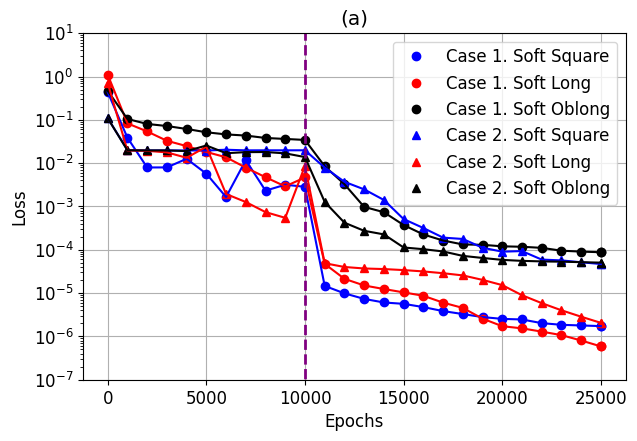

In [75]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)

fig = plt.figure(figsize=(7,4.5))
plt.plot(epochs_array, loss1, 'o', color='blue')
plt.plot(epochs_array, loss2, 'o', color='red')
plt.plot(epochs_array, loss3, 'o', color='black')

plt.plot(epochs_array, loss4, '^', color='blue')
plt.plot(epochs_array, loss5, '^', color='red')
plt.plot(epochs_array, loss6, '^', color='black')

plt.plot(epochs_array, loss1, color='blue')
plt.plot(epochs_array, loss2, color='red')
plt.plot(epochs_array, loss3, color='black')

plt.plot(epochs_array, loss4, color='blue')
plt.plot(epochs_array, loss5, color='red')
plt.plot(epochs_array, loss6, color='black')

#plt.legend([r'$\mathcal{L}_c$', r'$\mathcal{L}_b$'])
plt.title('(a)')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=90)
plt.yscale('log')
plt.ylim(0.0000001,10)
plt.grid()

plt.vlines(x=10000, ymin=0.00000001, ymax=10, colors='purple', ls='--', lw=2)

plt.legend(['Case 1. Soft Square','Case 1. Soft Long','Case 1. Soft Oblong','Case 2. Soft Square','Case 2. Soft Long','Case 2. Soft Oblong'], loc = "upper right")

plt.savefig("laplace_soft_loss_pic", bbox_inches = 'tight')

# Hard-PINN Loss Plot

In [52]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_hard_square_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,1]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25002)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\347688437.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_hard_square_loss",


In [53]:
loss7 = pde_loss_array

In [54]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_hard_long_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,1]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25002)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\1323185123.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_hard_long_loss",


In [55]:
loss8 = pde_loss_array

In [56]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_hard_oblong_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,1]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\3426252670.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace1_hard_oblong_loss",


In [57]:
loss9 = pde_loss_array

In [58]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_square_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,1]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25002)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\1141530042.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_square_loss",


In [59]:
loss10 = pde_loss_array

In [60]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_long_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,1]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\3569928800.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_long_loss",


In [61]:
loss11 = pde_loss_array

In [62]:
loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_oblong_loss", 
            delim_whitespace=True)
pde_loss = loss.to_numpy()[:,1]

epochs = np.arange(0,26000,1000)
epochs_array = np.append(epochs,25001)

pde_loss_array = np.append(pde_loss[:11], pde_loss[12:])

C:\Users\charl\AppData\Local\Temp\ipykernel_15748\3905139272.py:1: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  loss = pd.read_csv("C:/Users/charl/College/acm40980/acm40980_code/laplace2_hard_oblong_loss",


In [63]:
loss12 = pde_loss_array

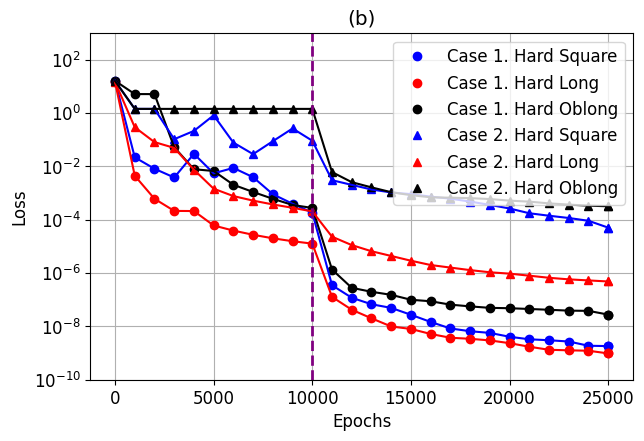

In [76]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)

fig = plt.figure(figsize=(7,4.5))
plt.plot(epochs_array, loss7, 'o', color='blue')
plt.plot(epochs_array, loss8, 'o', color='red')
plt.plot(epochs_array, loss9, 'o', color='black')

plt.plot(epochs_array, loss10, '^', color='blue')
plt.plot(epochs_array, loss11, '^', color='red')
plt.plot(epochs_array, loss12, '^', color='black')

plt.plot(epochs_array, loss7, color='blue')
plt.plot(epochs_array, loss8, color='red')
plt.plot(epochs_array, loss9, color='black')

plt.plot(epochs_array, loss10, color='blue')
plt.plot(epochs_array, loss11, color='red')
plt.plot(epochs_array, loss12, color='black')

#plt.legend([r'$\mathcal{L}_c$', r'$\mathcal{L}_b$'])
plt.title('(b)')
plt.xlabel('Epochs')
plt.ylabel('Loss', rotation=90)
plt.yscale('log')
plt.ylim(0.0000000001,1000)
plt.grid()

plt.vlines(x=10000, ymin=0.0000000001, ymax=1000, colors='purple', ls='--', lw=2)

plt.legend(['Case 1. Hard Square','Case 1. Hard Long','Case 1. Hard Oblong','Case 2. Hard Square','Case 2. Hard Long','Case 2. Hard Oblong'], loc = "upper right")

plt.savefig("laplace_hard_loss_pic", bbox_inches = 'tight')

# Relative Error - Test

In [67]:
def u1(x, y): 
    return (np.sinh(np.pi*y)/np.sinh(np.pi))*np.sin(np.pi*x)

In [87]:
def u2(x, y): 
    sum = 0
    for k in range(1,200):
        sum = sum + -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*y*k) * np.sinh(np.pi*(1-x)*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*y*k) * np.sinh(np.pi*x*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*x*k) * np.sinh(np.pi*(1-y)*k))/(np.pi**3 * k**3) -(4 * (-1 + (-1)**k) * (1/np.sinh(np.pi*k)) * np.sin(np.pi*x*k) * np.sinh(np.pi*y*k))/(np.pi**3 * k**3)
    return sum

In [99]:
Nx = 100
Ny = 100

xmin, xmax, ymin, ymax = [0.1, 0.9, 0.1, 0.9]
plot_grid = np.mgrid[xmin : xmax : Nx * 1j, ymin : ymax : Ny * 1j]

points = np.vstack((
    plot_grid[0].ravel(), 
    plot_grid[1].ravel()
    ))

In [100]:
test = np.concatenate([points[0].reshape(len(points[0]),1),
                       points[1].reshape(len(points[0]),1)], axis=1)

In [101]:
u1_exact = u1(points[0],points[1])

u_square_1_s = model_square_1_s.predict(test)
u_long_1_s = model_long_1_s.predict(test)
u_oblong_1_s = model_oblong_1_s.predict(test)

u_square_1_h = model_square_1_h.predict(test)
u_long_1_h = model_long_1_h.predict(test)
u_oblong_1_h = model_oblong_1_h.predict(test)

u2_exact = u2(points[0],points[1])

u_square_2_s = model_square_2_s.predict(test)
u_long_2_s = model_long_2_s.predict(test)
u_oblong_2_s = model_oblong_2_s.predict(test)

u_square_2_h = model_square_2_h.predict(test)
u_long_2_h = model_long_2_h.predict(test)
u_oblong_2_h = model_oblong_2_h.predict(test)

In [102]:
print(dde.metrics.l2_relative_error(np.round(u1_exact,15), np.round(u_square_1_s.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u1_exact,15), np.round(u_long_1_s.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u1_exact,15), np.round(u_oblong_1_s.flatten(),15)))

print(dde.metrics.l2_relative_error(np.round(u1_exact,15), np.round(u_square_1_h.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u1_exact,15), np.round(u_long_1_h.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u1_exact,15), np.round(u_oblong_1_h.flatten(),15)))

print(dde.metrics.l2_relative_error(np.round(u2_exact,15), np.round(u_square_2_s.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u2_exact,15), np.round(u_long_2_s.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u2_exact,15), np.round(u_oblong_2_s.flatten(),15)))

print(dde.metrics.l2_relative_error(np.round(u2_exact,15), np.round(u_square_2_h.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u2_exact,15), np.round(u_long_2_h.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u2_exact,15), np.round(u_oblong_2_h.flatten(),15)))

0.00037225289497446357
0.0001592630492548944
0.003248063690995968
3.590724734221195e-07
2.3451464613932812e-07
2.292688385616678e-06
0.002975638485974848
0.0002714781839743835
0.0029328906029675774
0.00014779085483306864
1.3746857647909058e-05
0.0002979353726733143


In [104]:
print(dde.metrics.l2_relative_error(np.round(u1_exact,15), np.round(u_square_1_s.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u1_exact,15), np.round(u_long_1_s.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u1_exact,15), np.round(u_oblong_1_s.flatten(),15)))

print(dde.metrics.l2_relative_error(np.round(u2_exact,15), np.round(u_square_2_s.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u2_exact,15), np.round(u_long_2_s.flatten(),15)))
print(dde.metrics.l2_relative_error(np.round(u2_exact,15), np.round(u_oblong_2_s.flatten(),15)))

0.00037225289497446357
0.0001592630492548944
0.003248063690995968
0.002975638485974848
0.0002714781839743835
0.0029328906029675774


# Absolute Error 

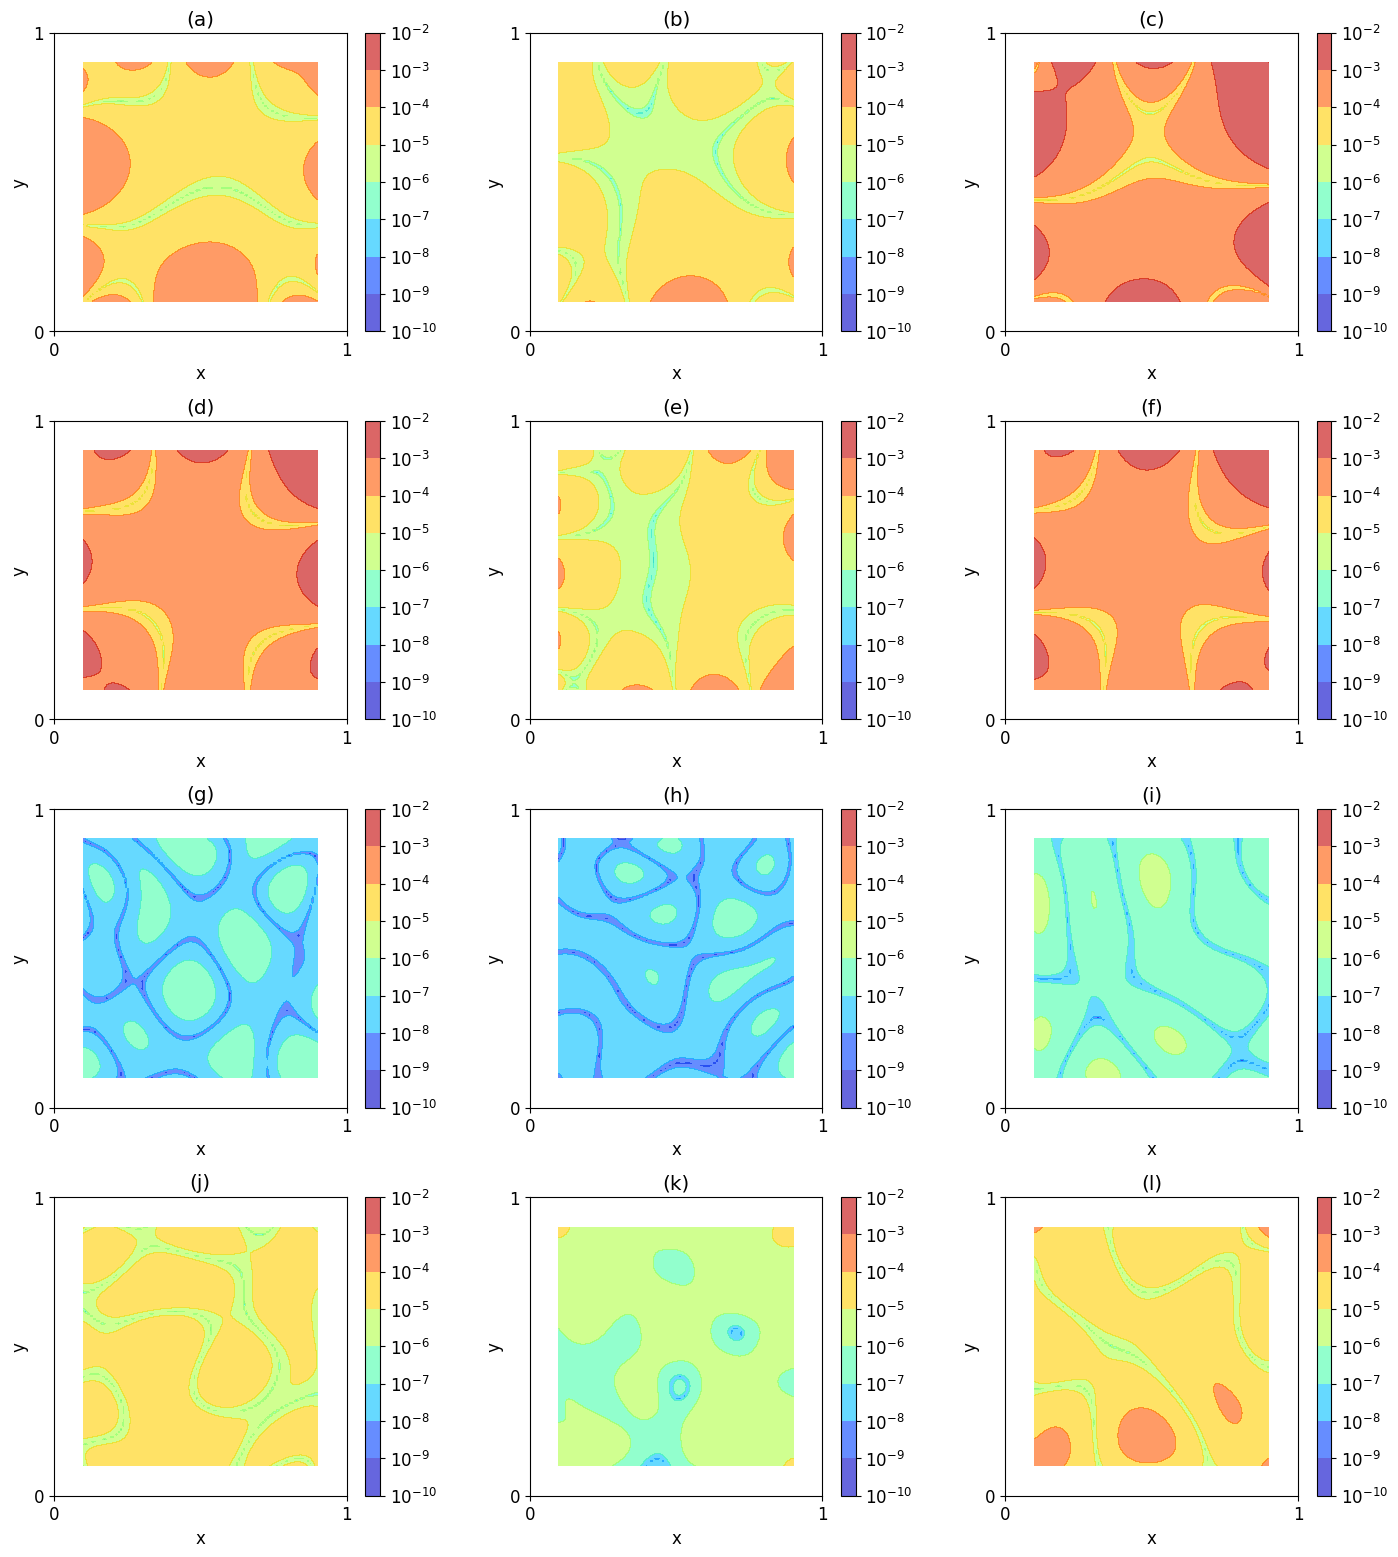

In [103]:
from matplotlib import cm, ticker

font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 12}
plt.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(17,19))

levels = np.logspace(np.log10(10**-10), np.log10(10**-2), num=9)

#ROW 1
#IMAGE 1
ax1 = fig.add_subplot(4,3,1)
error_square = np.abs(u_square_1_s.reshape((Nx,Ny)) - u1_exact.reshape((Nx,Ny)))
er1 = ax1.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('(a)');
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xticks([0,1])
ax1.set_yticks([0,1])
#IMAGE 2
ax2 = fig.add_subplot(4,3,2)
error_long = np.abs(u_long_1_s.reshape((Nx,Ny)) - u1_exact.reshape((Nx,Ny)))
er2 = ax2.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title('(b)');
ax2.set_xlabel('x')
ax2.set_ylabel('y')
ax2.set_xticks([0,1])
ax2.set_yticks([0,1])
#IMAGE 3
ax3 = fig.add_subplot(4,3,3)
error_oblong = np.abs(u_oblong_1_s.reshape((Nx,Ny)) - u1_exact.reshape((Nx,Ny)))
er3 = ax3.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax3.set_xticks([])
ax3.set_yticks([])
ax3.set_title('(c)');
ax3.set_xlabel('x')
ax3.set_ylabel('y')
ax3.set_xticks([0,1])
ax3.set_yticks([0,1])
#IMAGE 4
ax4 = fig.add_subplot(4,3,4)
error_square = np.abs(u_square_2_s.reshape((Nx,Ny)) - u2_exact.reshape((Nx,Ny)))
er4 = ax4.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax4.set_xticks([])
ax4.set_yticks([])
ax4.set_title('(d)');
ax4.set_xlabel('x')
ax4.set_ylabel('y')
ax4.set_xticks([0,1])
ax4.set_yticks([0,1])
#IMAGE 5
ax5 = fig.add_subplot(4,3,5)
error_long = np.abs(u_long_2_s.reshape((Nx,Ny)) - u2_exact.reshape((Nx,Ny)))
er5 = ax5.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax5.set_xticks([])
ax5.set_yticks([])
ax5.set_title('(e)');
ax5.set_xlabel('x')
ax5.set_ylabel('y')
ax5.set_xticks([0,1])
ax5.set_yticks([0,1])
#IMAGE 6
ax6 = fig.add_subplot(4,3,6)
error_oblong = np.abs(u_oblong_2_s.reshape((Nx,Ny)) - u2_exact.reshape((Nx,Ny)))
er6 = ax6.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax6.set_xticks([])
ax6.set_yticks([])
ax6.set_title('(f)');
ax6.set_xlabel('x')
ax6.set_ylabel('y')
ax6.set_xticks([0,1])
ax6.set_yticks([0,1])

#ROW 2
#IMAGE 1
ax7 = fig.add_subplot(4,3,7)
error_square = np.abs(u_square_1_h.reshape((Nx,Ny)) - u1_exact.reshape((Nx,Ny)))
er7 = ax7.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax7.set_xticks([])
ax7.set_yticks([])
ax7.set_title('(g)');
ax7.set_xlabel('x')
ax7.set_ylabel('y')
ax7.set_xticks([0,1])
ax7.set_yticks([0,1])
#IMAGE 2
ax8 = fig.add_subplot(4,3,8)
error_long = np.abs(u_long_1_h.reshape((Nx,Ny)) - u1_exact.reshape((Nx,Ny)))
er8 = ax8.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax8.set_xticks([])
ax8.set_yticks([])
ax8.set_title('(h)');
ax8.set_xlabel('x')
ax8.set_ylabel('y')
ax8.set_xticks([0,1])
ax8.set_yticks([0,1])
#IMAGE 3
ax9 = fig.add_subplot(4,3,9)
error_oblong = np.abs(u_oblong_1_h.reshape((Nx,Ny)) - u1_exact.reshape((Nx,Ny)))
er9 = ax9.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax9.set_xticks([])
ax9.set_yticks([])
ax9.set_title('(i)');
ax9.set_xlabel('x')
ax9.set_ylabel('y')
ax9.set_xticks([0,1])
ax9.set_yticks([0,1])
#IMAGE 4
ax10 = fig.add_subplot(4,3,10)
error_square = np.abs(u_square_2_h.reshape((Nx,Ny)) - u2_exact.reshape((Nx,Ny)))
er10 = ax10.contourf(plot_grid[0], plot_grid[1], error_square, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax10.set_xticks([])
ax10.set_yticks([])
ax10.set_title('(j)');
ax10.set_xlabel('x')
ax10.set_ylabel('y')
ax10.set_xticks([0,1])
ax10.set_yticks([0,1])
#IMAGE 5
ax11 = fig.add_subplot(4,3,11)
error_long = np.abs(u_long_2_h.reshape((Nx,Ny)) - u2_exact.reshape((Nx,Ny)))
er11 = ax11.contourf(plot_grid[0], plot_grid[1], error_long, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax11.set_xticks([])
ax11.set_yticks([])
ax11.set_title('(k)');
ax11.set_xlabel('x')
ax11.set_ylabel('y')
ax11.set_xticks([0,1])
ax11.set_yticks([0,1])
#IMAGE 6
ax12 = fig.add_subplot(4,3,12)
error_oblong = np.abs(u_oblong_2_h.reshape((Nx,Ny)) - u2_exact.reshape((Nx,Ny)))
er12 = ax12.contourf(plot_grid[0], plot_grid[1], error_oblong, cmap='jet', alpha=0.6, locator=ticker.LogLocator(), vmin=10**-10, vmax=10**-2, levels=levels)
ax12.set_xticks([])
ax12.set_yticks([])
ax12.set_title('(l)');
ax12.set_xlabel('x')
ax12.set_ylabel('y')
ax12.set_xticks([0,1])
ax12.set_yticks([0,1])

fig.colorbar(er1)
fig.colorbar(er2)
fig.colorbar(er3)
fig.colorbar(er4)
fig.colorbar(er5)
fig.colorbar(er6)
fig.colorbar(er7)
fig.colorbar(er8)
fig.colorbar(er9)
fig.colorbar(er10)
fig.colorbar(er11)
fig.colorbar(er12)

plt.subplots_adjust(hspace=0.3, wspace=0.3)
#plt.savefig("laplace_error", bbox_inches = 'tight')

# Training Points

In [ ]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 10}
plt.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(5,4.5))

vmin=0
vmax=1

#ROW 1
#IMAGE 1
ax1 = fig.add_subplot(1,1,1)
im = ax1.contourf(plot_grid[0], plot_grid[1], u1_exact.reshape((Nx,Ny)), cmap='jet', alpha=0.4, vmin=0, vmax=1, levels=10)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('(a)');
ax1.scatter(data1.train_x_all[:,0], data1.train_x_all[:,1], marker='.', c='black')
ax1.scatter(data1.train_x_bc[:,0], data1.train_x_bc[:,1], marker='.', c='red')
ax1.set_ylim(-0.01,1.01)
ax1.set_xlim(-0.01,1.01)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xticks([0,0.5,1])
ax1.set_yticks([0,0.5,1])

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.savefig("laplace1_soft_points", bbox_inches = 'tight')

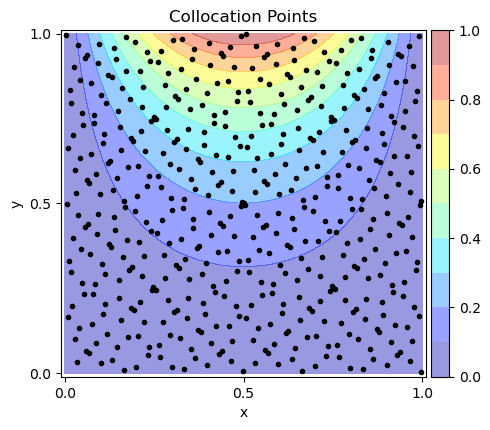

In [127]:
font = {'family': 'sans-serif',
        'weight': 'normal',
        'size': 10}
plt.rc('font', **font)

from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(5,4.5))

vmin=0
vmax=1

#ROW 1
#IMAGE 1
ax1 = fig.add_subplot(1,1,1)
im = ax1.contourf(plot_grid[0], plot_grid[1], u1_exact.reshape((Nx,Ny)), cmap='jet', alpha=0.4, vmin=0, vmax=1, levels=10)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title('Collocation Points');
ax1.scatter(data1_hard.train_x_all[:,0], data1_hard.train_x_all[:,1], marker='.', c='black')
ax1.scatter(data1_hard.train_x_bc[:,0], data1_hard.train_x_bc[:,1], marker='.', c='red')
ax1.set_ylim(-0.01,1.01)
ax1.set_xlim(-0.01,1.01)
ax1.set_xlabel('x')
ax1.set_ylabel('y')
ax1.set_xticks([0,0.5,1])
ax1.set_yticks([0,0.5,1])

divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im, cax=cax, orientation='vertical')

plt.savefig("laplace1_hard_points", bbox_inches = 'tight')

# Relative Error - Train

In [97]:
print(dde.metrics.l2_relative_error(u1(data_1_h.train_x_all.T[0], data_1_h.train_x_all.T[1]), model_square_1_s.predict(data_1_h.train_x_all).T))
print(dde.metrics.l2_relative_error(u1(data_1_h.train_x_all.T[0], data_1_h.train_x_all.T[1]), model_long_1_s.predict(data_1_h.train_x_all).T))
print(dde.metrics.l2_relative_error(u1(data_1_h.train_x_all.T[0], data_1_h.train_x_all.T[1]), model_oblong_1_s.predict(data_1_h.train_x_all).T))

0.0007110649001233093
0.000314740849905398
0.005556334519977543


In [98]:
print(dde.metrics.l2_relative_error(u2(data_2_h.train_x_all.T[0], data_2_h.train_x_all.T[1]), model_square_2_s.predict(data_2_h.train_x_all).T))
print(dde.metrics.l2_relative_error(u2(data_2_h.train_x_all.T[0], data_2_h.train_x_all.T[1]), model_long_2_s.predict(data_2_h.train_x_all).T))
print(dde.metrics.l2_relative_error(u2(data_2_h.train_x_all.T[0], data_2_h.train_x_all.T[1]), model_oblong_2_s.predict(data_2_h.train_x_all).T))

0.007484297677892893
0.0014785998214424138
0.007409215560372852
